In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [28]:
set.seed(50)
heart_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE) |>
    rename("age"= X1, "sex" = X2, "chest_pain" = X3, "trestbps" = X4, "chol" = X5, "fasting_bs" = X6, "restecg" = X7, "max_heart_rate" = X8, "exang" = X9, "old_peak" = X10, "peak_slope" = X11, "ca" = X12, "thal" = X13, "predicted" = X14) |>
    mutate(sex = recode(sex, "1" = "male", "0" = "female")) |>
    mutate(chest_pain = recode(chest_pain, "1" = "typical_angina", "2" = "atypical_angina", "3" = "non_anginal_pain", "4" = "asymptomatic")) |>
    mutate(trestbps = as.integer(trestbps)) |>
    mutate(chol = as.integer(chol)) |>
    mutate(fasting_bs = recode(fasting_bs, "1" = "over_120", "0" = "under_120")) |>
    mutate(restecg = recode(restecg, "0" = "normal", "1" = "abnormal", "2" = "hypertrophy")) |>
    mutate(max_heart_rate = as.integer(max_heart_rate)) |>
    mutate(old_peak = as.numeric(old_peak)) |>
    mutate(ca = as.integer(ca)) |>
    mutate(exang = recode(exang, "0" = "no", "1" = "yes")) |>
    mutate(peak_slope = as.integer(peak_slope)) |>
    mutate(thal = recode(thal, "3.0" = "normal", "6.0" = "fixed_defect", "7.0" = "reversable_defect")) |>
    mutate(predicted = as.factor(predicted)) |>
    mutate(predicted = recode(predicted, "0" = "no_cvd", "1" = "cvd", "2" = "cvd", "3" = "cvd", "4" = "cvd")) |>
    na.omit() 


heart_split <- initial_split(heart_data, prop = 0.75, strata = predicted)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train

# age + chest_pain + trestbps + chol + max_heart_rate







Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,chest_pain,trestbps,chol,fasting_bs,restecg,max_heart_rate,exang,old_peak,peak_slope,ca,thal,predicted
<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>,<int>,<chr>,<fct>
67,male,asymptomatic,160,286,under_120,hypertrophy,108,yes,1.5,2,3,normal,cvd
67,male,asymptomatic,120,229,under_120,hypertrophy,129,yes,2.6,2,2,reversable_defect,cvd
62,female,asymptomatic,140,268,under_120,hypertrophy,160,no,3.6,3,2,normal,cvd
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,male,atypical_angina,130,221,under_120,hypertrophy,163,no,0.0,1,0,reversable_defect,no_cvd
55,female,atypical_angina,132,342,under_120,normal,166,no,1.2,1,0,normal,no_cvd
41,male,atypical_angina,120,157,under_120,normal,182,no,0.0,1,0,normal,no_cvd


`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


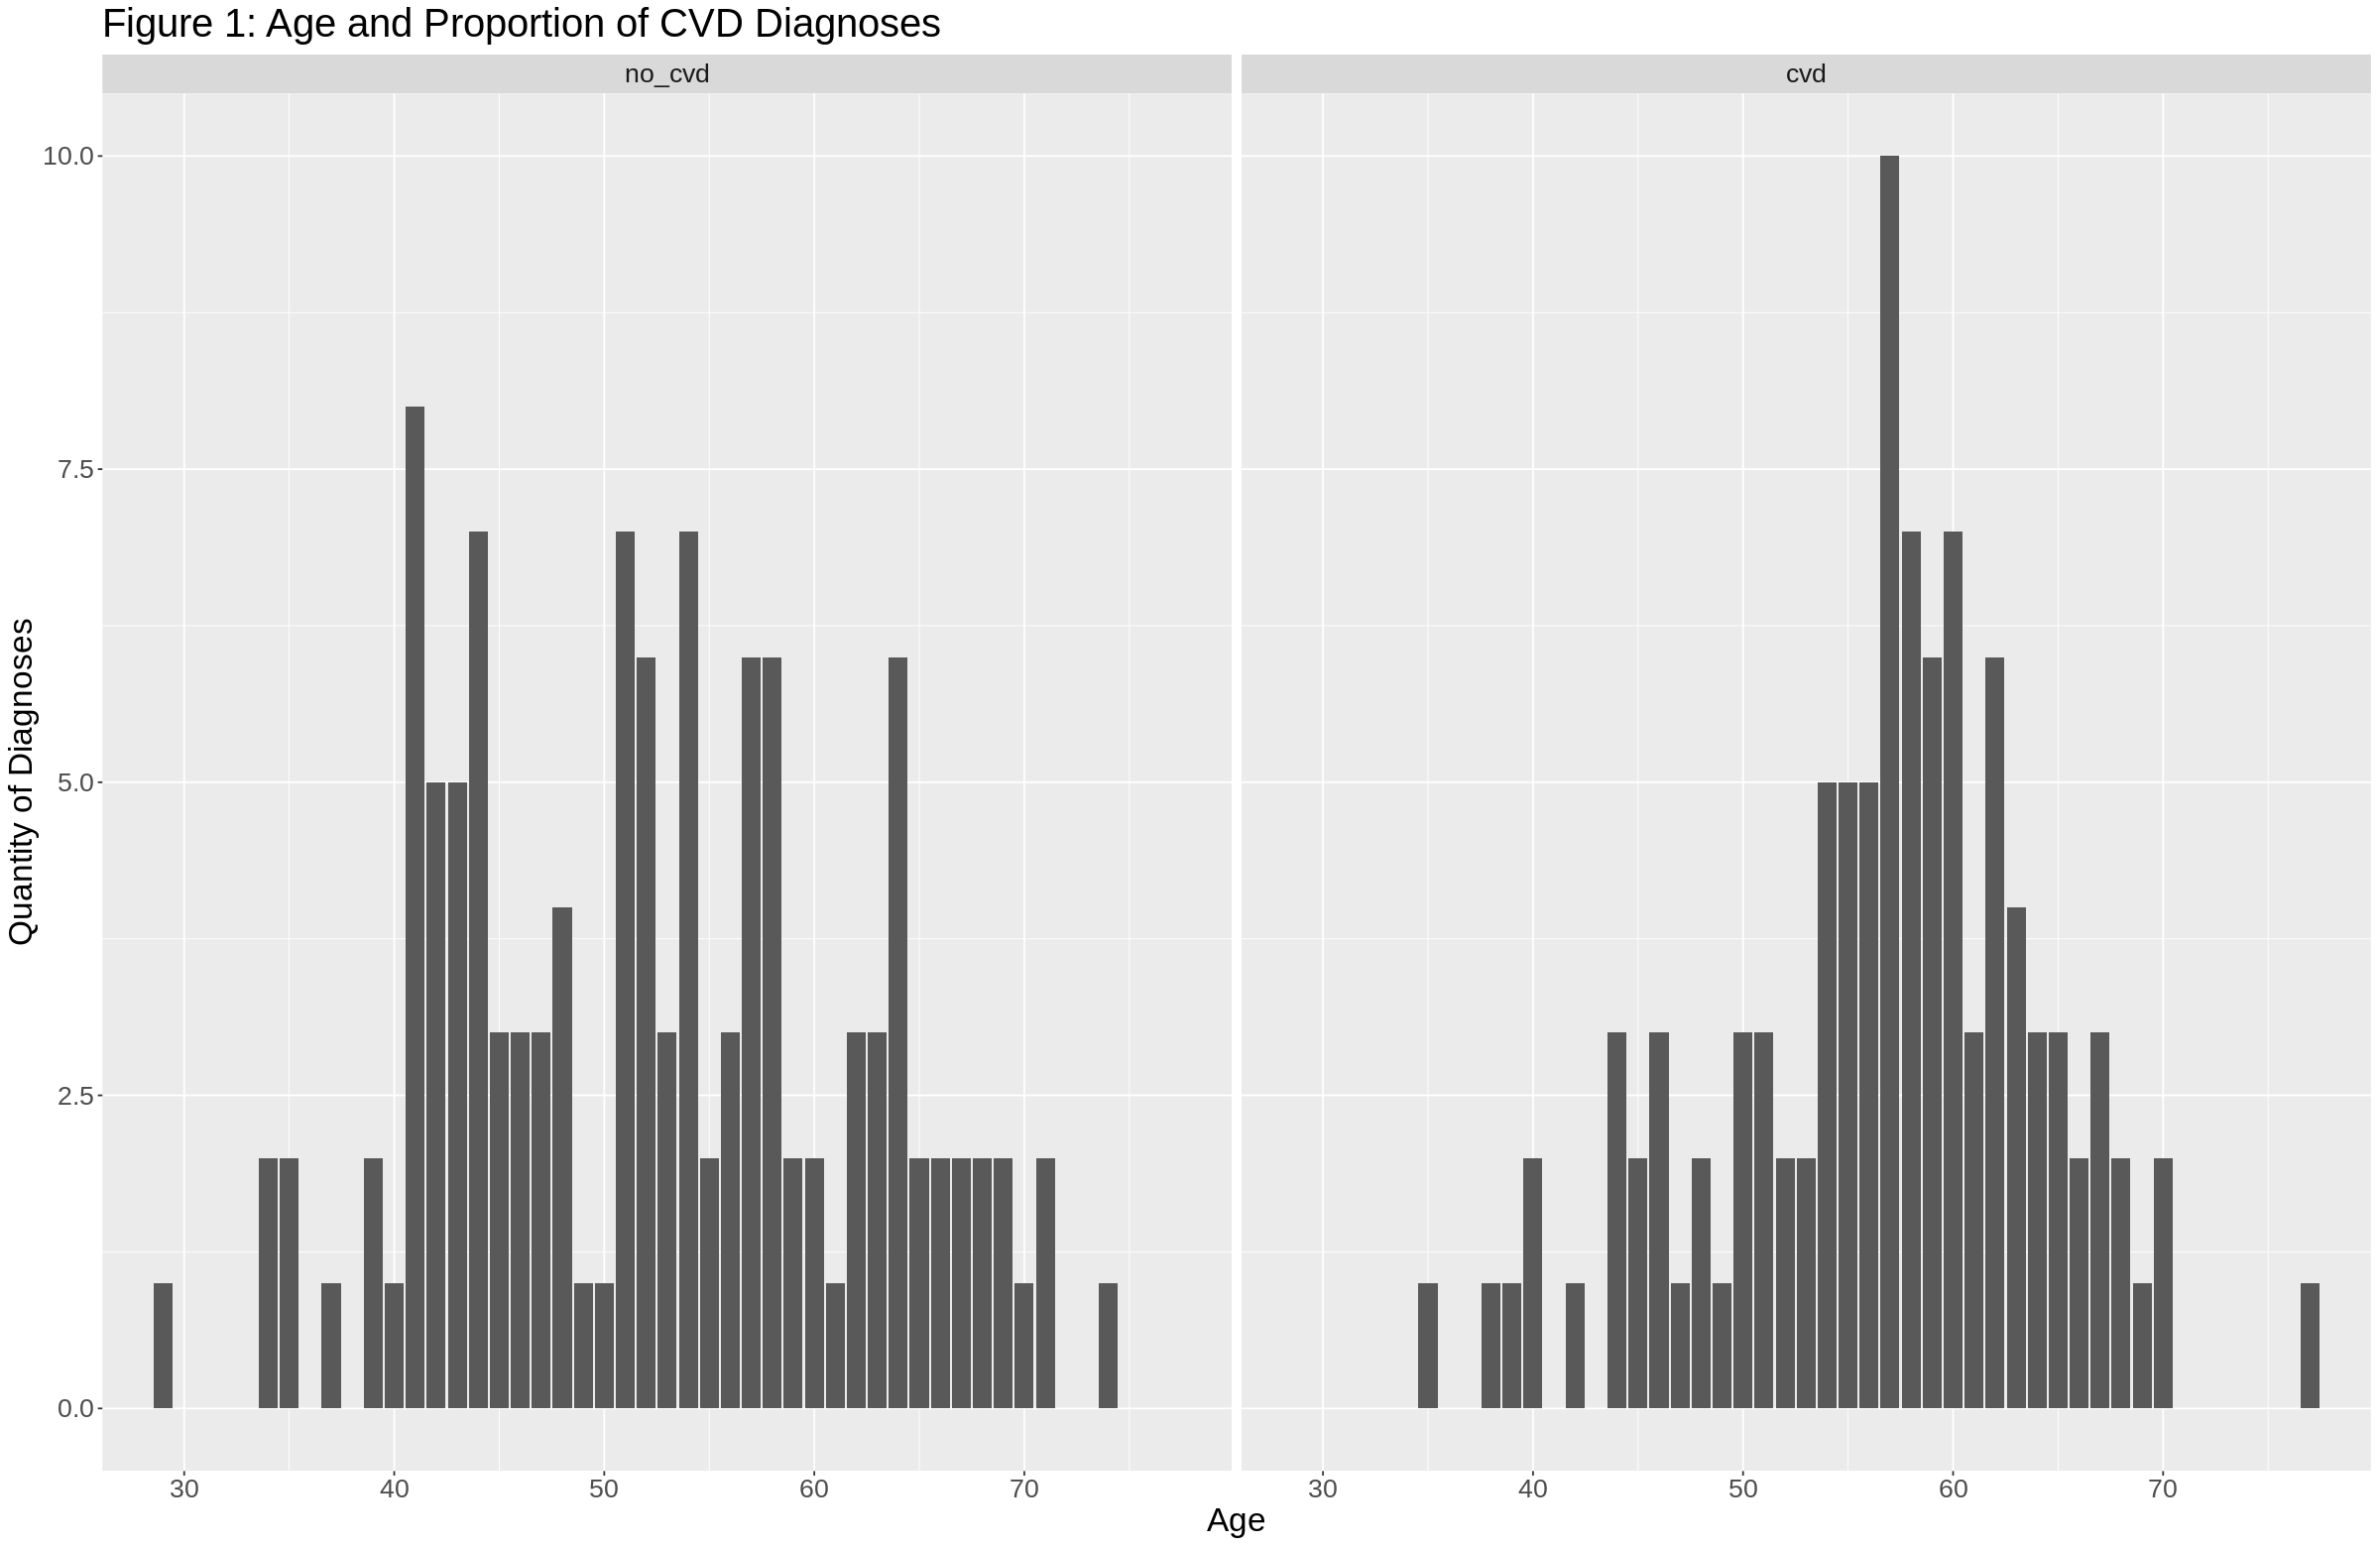

In [40]:
options(repr.plot.width = 20, repr.plot.height = 13) 
cvd_age_count <- heart_train |>
    group_by(age, predicted) |>
    summarize(count = n())

cvd_age_plot <- cvd_age_count |>
    ggplot(aes(x = age, y = count)) +
    geom_bar(stat = "identity") +
    labs(x = "Age", y = "Quantity of Diagnoses") +
    scale_fill_discrete(labels = c("No CVD Present", "CVD Present")) +
    ggtitle("Figure 1: Age and Proportion of CVD Diagnoses") + 
    facet_grid(cols = vars(predicted)) +
    theme(text = element_text(size = 20)) 

cvd_age_plot

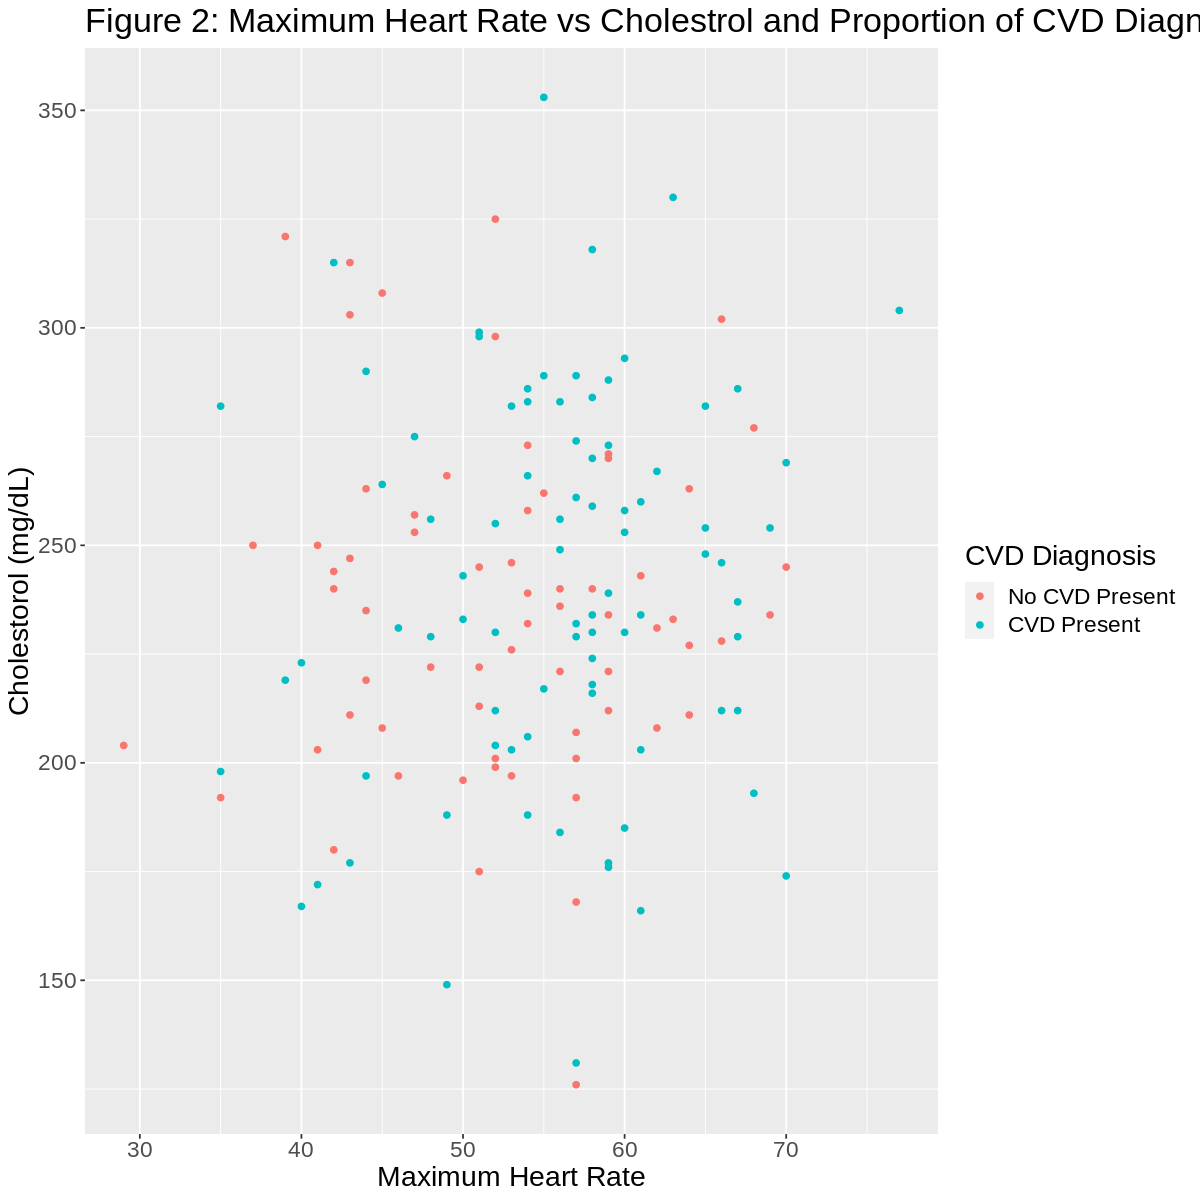

In [27]:
options(repr.plot.width = 10, repr.plot.height = 10)

chol_age_plot <- heart_train |>
    ggplot(aes(x = age, y = chol, color = predicted)) + 
    geom_point() +
    labs(x = "Maximum Heart Rate", y = "Cholestorol (mg/dL)", color = "CVD Diagnosis") + 
    scale_color_discrete(labels = c("No CVD Present", "CVD Present")) +
     ggtitle("Figure 2: Maximum Heart Rate vs Cholestrol and Proportion of CVD Diagnoses") + 
    theme(text = element_text(size = 17))
chol_age_plot

# chol leads to CVD as people age when chol is below 300 

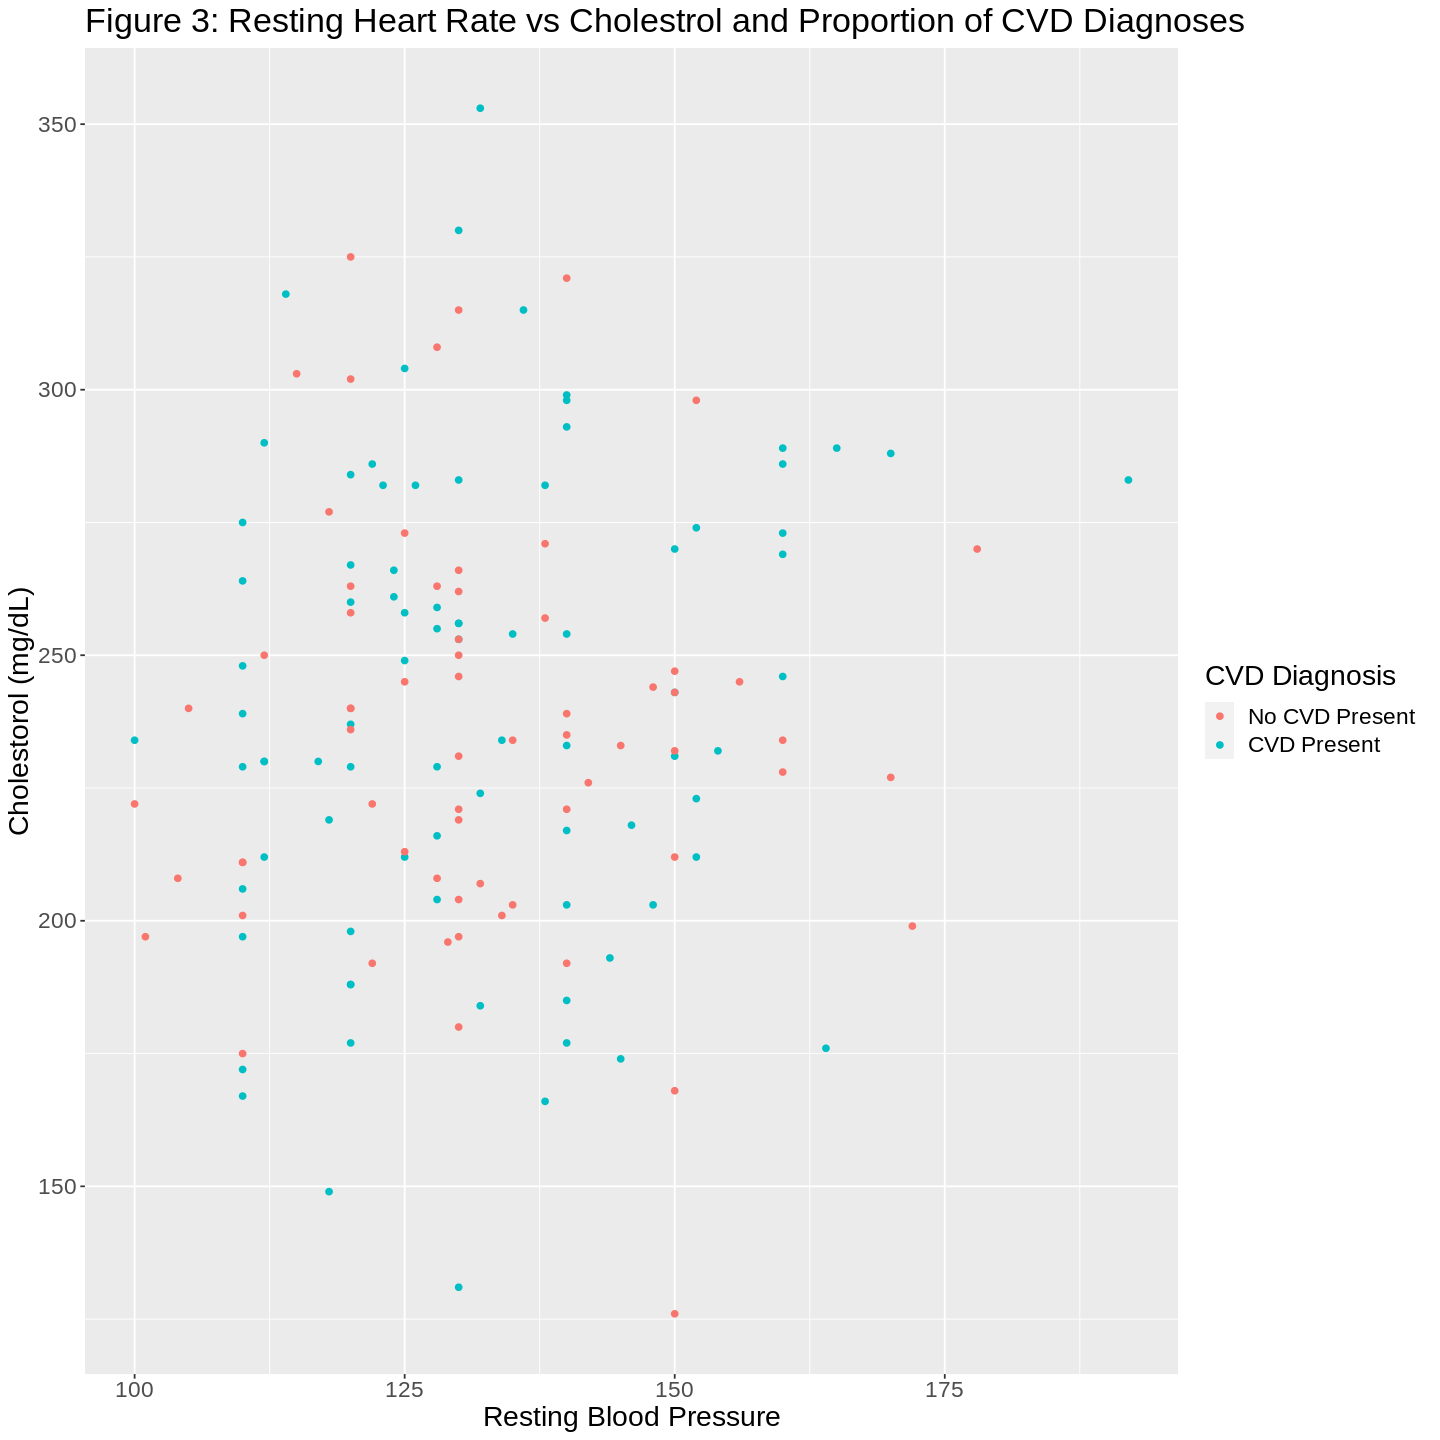

In [26]:
options(repr.plot.width = 12, repr.plot.height = 12)

chol_rest_plot <- heart_train |>
    ggplot(aes(x = trestbps , y = chol, color = predicted)) +
    geom_point() +
    labs(x = "Resting Blood Pressure", y = "Cholestorol (mg/dL)", color = "CVD Diagnosis") + 
    scale_color_discrete(labels = c("No CVD Present", "CVD Present")) +
    ggtitle("Figure 3: Resting Heart Rate vs Cholestrol and Proportion of CVD Diagnoses") + 
    theme(text = element_text(size = 17))

chol_rest_plot

#chol below 300 and resting around 125 appears to be healthy and likely does not lead to CVD 

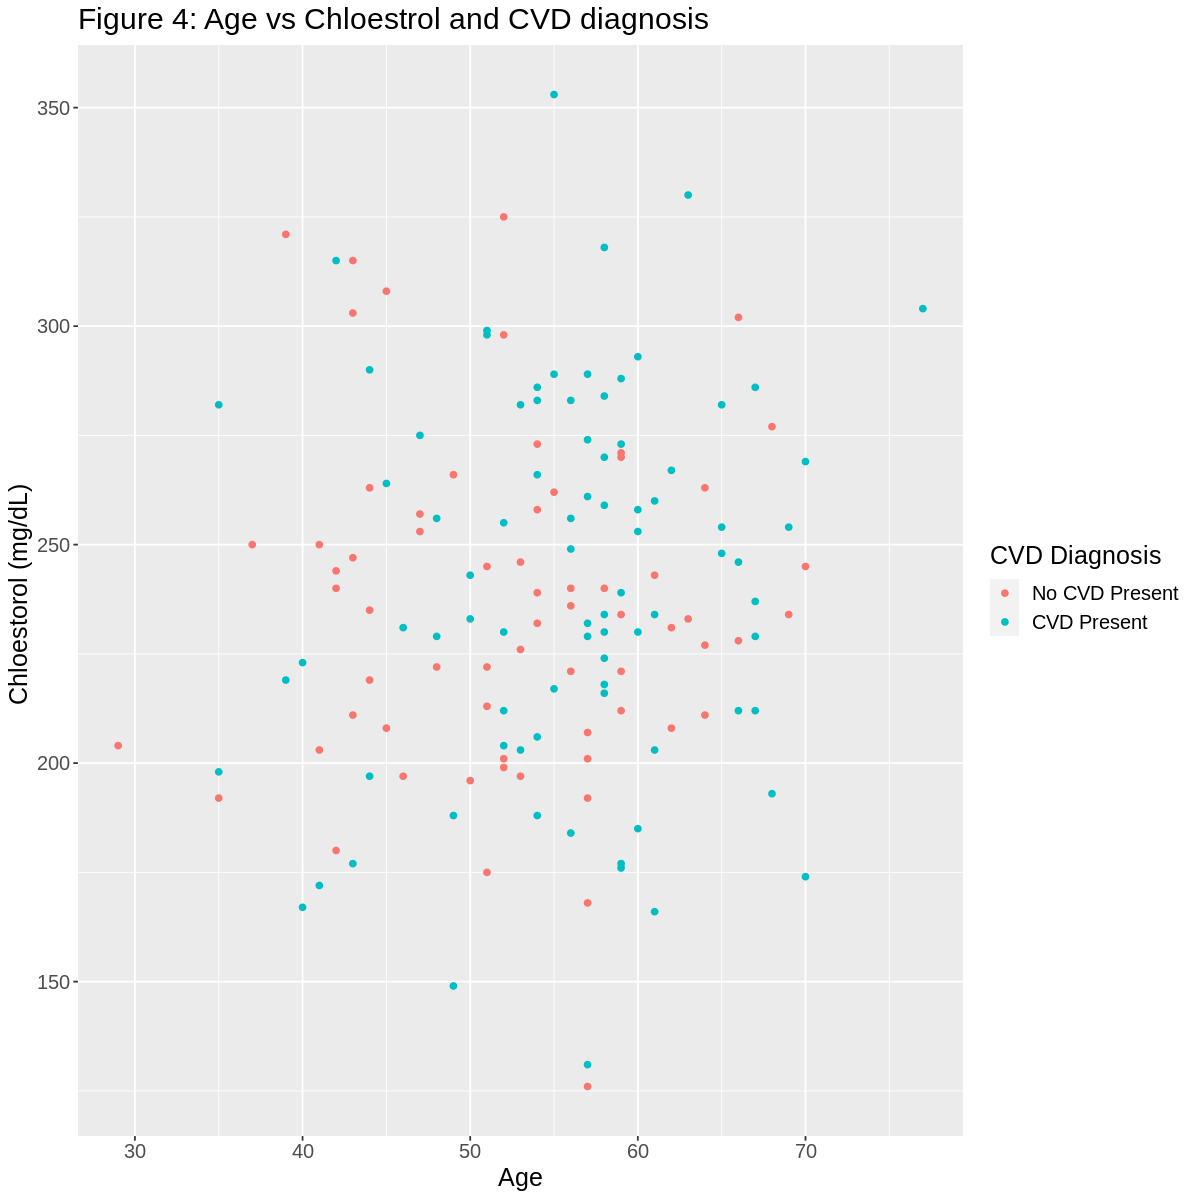

In [25]:
options(repr.plot.width = 10, repr.plot.height = 10)

chol_age_plot <- heart_train |> 
    ggplot(aes(x = age, y =  chol, color = predicted)) +
    geom_point() + 
    scale_color_discrete(labels = c("No CVD Present", "CVD Present")) +
    labs(x = "Age", y = "Chloestorol (mg/dL) ", color = "CVD Diagnosis") + 
    ggtitle("Figure 4: Age vs Chloestrol and CVD diagnosis") +
    theme(text = element_text(size = 15)) 
chol_age_plot

# Chol could increase with age. CVD diagnosis definitley increase with age and low chol cannot help reduce chances of CVD in this case. 

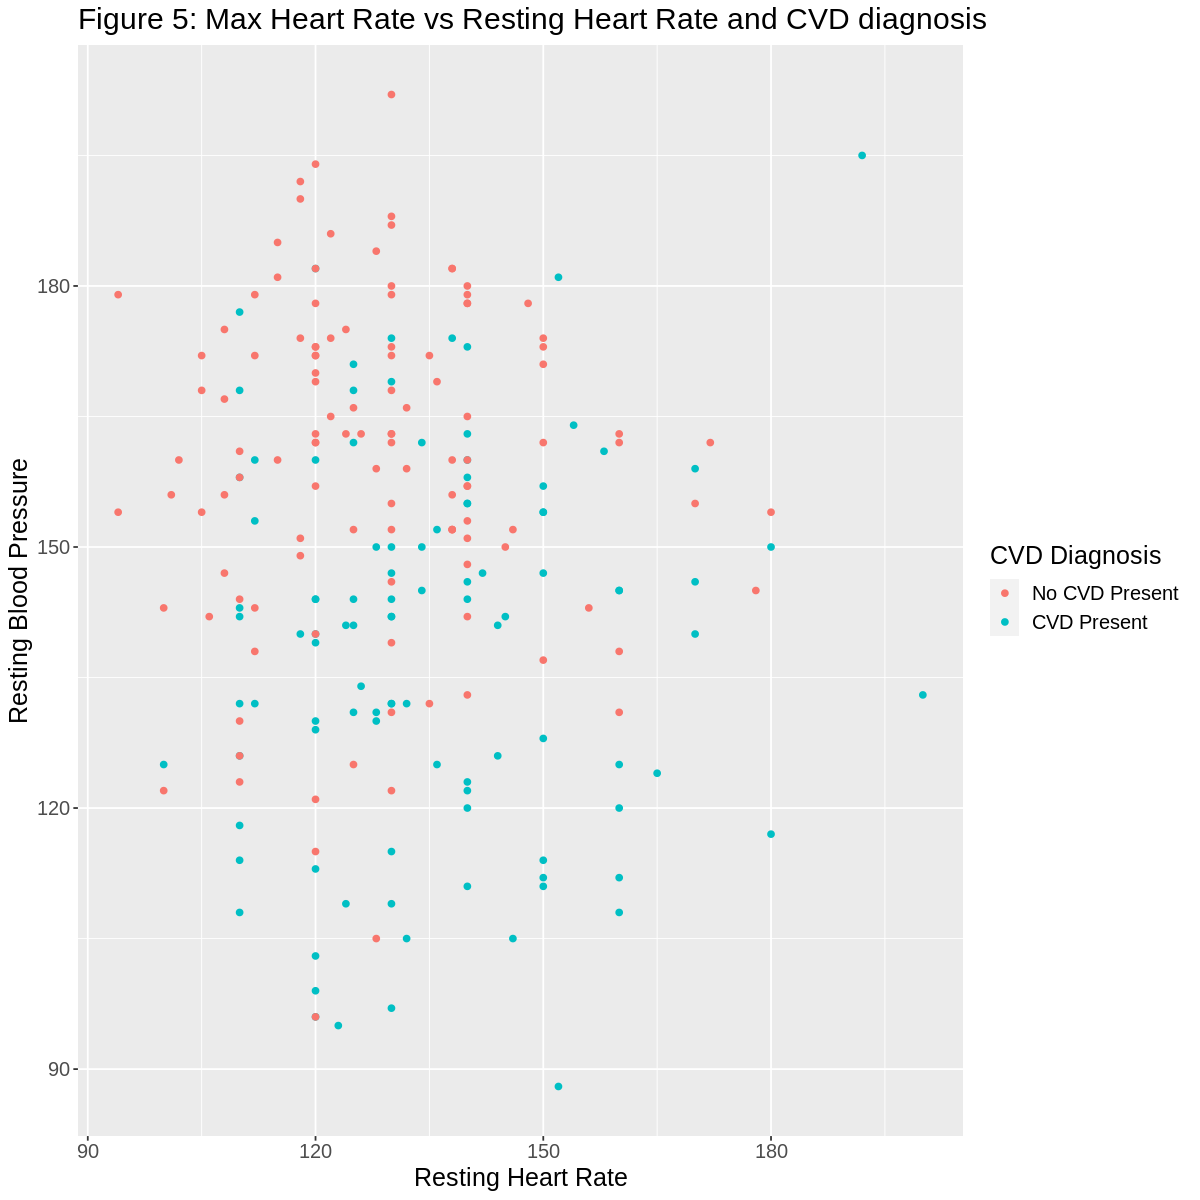

In [17]:
options(repr.plot.width = 10, repr.plot.height = 10)

rest_max_plot <- heart_train |>
    ggplot(aes(x = trestbps, y = max_heart_rate, color = predicted)) + 
    geom_point() +
    scale_color_discrete(labels = c("No CVD Present", "CVD Present")) +
    labs(x = "Resting Heart Rate", y = "Resting Blood Pressure", color = "CVD Diagnosis") + 
    ggtitle("Figure 5: Max Heart Rate vs Resting Heart Rate and CVD diagnosis") +
    theme(text = element_text(size = 15)) 
rest_max_plot

# low max heart rate leads to CVD likely 